In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scvelo as scv
from scipy import stats
import os


/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/numba/errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()


scanpy==1.4+331.g0047163 anndata==0.6.19 numpy==1.17.1 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.22.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [4]:
scv.logging.print_versions()

scvelo==0.1.16  scanpy==1.4+331.g0047163  anndata==0.6.19  loompy==2.0.12  numpy==1.17.1  scipy==1.1.0  matplotlib==2.2.4  sklearn==0.22.1  pandas==0.23.4  


## Import zUMI Dataset

In [7]:
#Import all datasets datasets
st08_z = sc.read_loom(
    '/work/sduknn/Andreas/xenopus/zUMI_out/scCapSt08/zUMIs_output/velocity/zUMI_scCapSt08.loom', )

st105_z = sc.read_loom(
    '/work/sduknn/Andreas/xenopus/zUMI_out/scCapSt105/zUMIs_output/velocity/zUMI_scCapSt105.loom')

st12_z = sc.read_loom(
    '/work/sduknn/Andreas/xenopus/zUMI_out/scCapSt12/zUMIs_output/velocity/zUMI_scCapSt12.loom')

st13_z = sc.read_loom(
    '/work/sduknn/Andreas/xenopus/zUMI_out/scCapSt13/zUMIs_output/velocity/zUMI_scCapSt13.loom')

st16_z = sc.read_loom(
    '/work/sduknn/Andreas/xenopus/zUMI_out/scCapSt16/zUMIs_output/velocity/zUMI_scCapSt16.loom')

st18_z = sc.read_loom(
    '/work/sduknn/Andreas/xenopus/zUMI_out/scCapSt18/zUMIs_output/velocity/zUMI_scCapSt18.loom')

st20_z = sc.read_loom(
    '/work/sduknn/Andreas/xenopus/zUMI_out/scCapSt20/zUMIs_output/velocity/zUMI_scCapSt20.loom')

st22_z = sc.read_loom(
    '/work/sduknn/Andreas/xenopus/zUMI_out/scCapSt22/zUMIs_output/velocity/zUMI_scCapSt22.loom')

st24_z = sc.read_loom(
    '/work/sduknn/Andreas/xenopus/zUMI_out/scCapSt24/zUMIs_output/velocity/zUMI_scCapSt24.loom')

st27_z = sc.read_loom(
    '/work/sduknn/Andreas/xenopus/zUMI_out/scCapSt27/zUMIs_output/velocity/zUMI_scCapSt27.loom')



In [8]:
st08_z.obs['stage'] = 'st08'
st105_z.obs['stage'] = 'st10.5'
st12_z.obs['stage'] = 'st12'
st13_z.obs['stage'] = 'st13'
st16_z.obs['stage'] = 'st16'
st18_z.obs['stage'] = 'st18'
st20_z.obs['stage'] = 'st20'
st22_z.obs['stage'] = 'st22'
st24_z.obs['stage'] = 'st24'
st27_z.obs['stage'] = 'st27'

In [9]:
datasets_z = [st08_z, st105_z, st12_z, st13_z, st16_z, st18_z, st20_z, st22_z, st24_z, st27_z] 



In [5]:

def save_intermediate_files(datasets, temp_dir, file_name_template, identifier):
    for d in datasets:
        file = os.path.join('.', temp_dir, file_name_template + '_' + d.obs[identifier][0] + '.h5ad')
        d.write(file, compression='gzip')
        
identifiers = ['st08','st10.5','st12','st13','st16','st18','st20','st22','st24','st27']
      
def load_intermediate_files(temp_dir, file_name_template, identifiers):
    ob_list = []
    for i in identifiers:
        file = os.path.join('.', temp_dir, file_name_template + '_' + i+ '.h5ad')
        ob_list.append(sc.read_h5ad(file))
    return ob_list

In [6]:
save_intermediate_files(datasets_z, 'intermediate_files', 'zUMI_Unprocessed' , 'stage')

NameError: name 'datasets_z' is not defined

## Load complete

In [6]:

st08_z_u, st105_z_u, st12_z_u, st13_z_u, st16_z_u, st18_z_u, st20_z_u, st22_z_u, st24_z_u, st27_z_u = load_intermediate_files( 'intermediate_files', 'zUMI_Unprocessed' , identifiers)


In [7]:
datasets_z_u = [st08_z_u, st105_z_u, st12_z_u, st13_z_u, st16_z_u, st18_z_u, st20_z_u, st22_z_u, st24_z_u, st27_z_u]



## Load processed

In [8]:
st08_z_p, st105_z_p, st12_z_p, st13_z_p, st16_z_p, st18_z_p, st20_z_p, st22_z_p, st24_z_p, st27_z_p = load_intermediate_files( 'intermediate_files', 'zUMI_raw_singlets' , identifiers) 



In [9]:
datasets_z_p = [st08_z_p, st105_z_p, st12_z_p, st13_z_p, st16_z_p, st18_z_p, st20_z_p, st22_z_p, st24_z_p, st27_z_p]


## Save subsets

In [82]:
from multiprocessing import Pool


# Save individual stages as csv files and modify gene names to not include symbols, which yielded problems when loading in R
def save_subsets_p(datasets):
    u, p = datasets
    print('saving : {}'.format(p.obs['stage'][0]))
    df = pd.DataFrame(data = u.X.todense().T, 
             columns = [p.obs['stage'][0] + '_' + cut_zumi(bc) for bc in u.obs_names.tolist()], 
            index = [gene.replace('.', 'dotdotdot').replace('|', 'abcabcabc') for gene in u.var_names.tolist()])
    df = df.loc[:, [p.obs['stage'][0] + '_' + x for x in p.obs_names.tolist()]]
    pd.DataFrame(df.index).to_csv('data_cyto/{}genes_cyto.txt'.format(p.obs['stage'][0]), sep = '\t', header = False, index = False )
    df.to_csv('data_cyto/{}counts_cyto.txt'.format(p.obs['stage'][0]), sep = '\t', index = False )
    print('Finished saving: {}'.format(p.obs['stage'][0]))
    
def cut_zumi(bc):
    return bc.split(':')[1].strip('x')





In [ ]:
pool = Pool(10) 
pool.map(save_subsets_p, zip(datasets_z_u,datasets_z_p))

!R run_cytoTRACE.R

## Read cytotrace output and make plots

In [3]:
cyto = pd.read_csv('Xenopus_cytotrace/data_cyto/CytoTRACE_plot_table.txt', sep = '\t')

In [104]:
rank = pd.read_csv('Xenopus_cytotrace/data_cyto/cytotraceRank.tsv', sep = '\t', header = None)

In [4]:
import seaborn as sns


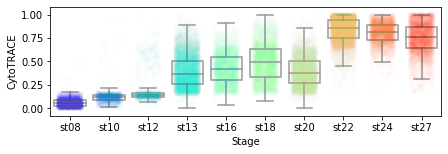

In [8]:
plt.figure(figsize=(7,2))
cluster_colors = pd.Series(sns.color_palette(
            'rainbow', 10), index=['st08','st10.5','st12','st13','st16','st18','st20','st22','st24','st27'])

sns.boxplot(x = 'Phenotype', y = 'CytoTRACE', data = cyto,color='white', orient="v", fliersize = 0, saturation = .0)
sns.stripplot(x = 'Phenotype', y = 'CytoTRACE', data = cyto, alpha = 0.01, size = 5,jitter = 0.3, palette = cluster_colors )
plt.xlabel('Stage')
plt.savefig('./intermediate_files/Figures/cytotrace_per_stage.pdf')